In [1]:
from PIL import Image
from aug_isic import ImgTrainTransform0, ImgTrainTransform1, ImgTrainTransform2, ImgTrainTransform3, ImgTrainTransform4, ImgEvalTransform, ImgTrainTransformWithPP
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline


<PIL.Image.Image image mode=RGB size=1024x768 at 0x7FA93C49AE10>


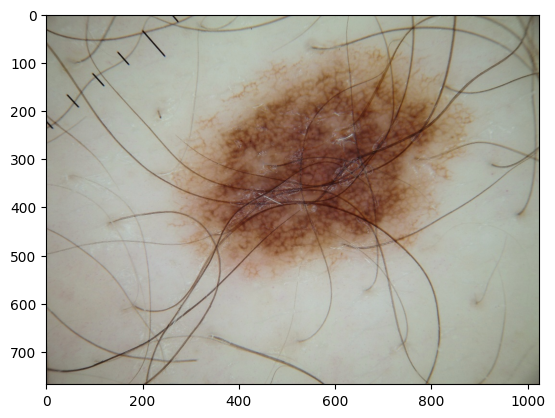

In [3]:
path = "/home/a52550/Desktop/datasets/ISIC2017/train/ISIC-2017_Training_Data/ISIC_0010006.jpg" #ISIC_0010847.jpg"
# path = "/home/a52550/Desktop/datasets/ISIC2017/train/cropped_images/ISIC_0014933.jpg"

image = Image.open(path).convert('RGB')
plt.imshow(image)
print(image)

In [ ]:
def dullrazor(img):
    #Gray scale
    grayScale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY )
    #Black hat filter
    kernel = cv2.getStructuringElement(1,(9,9)) 
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    #Gaussian filter
    bhg= cv2.GaussianBlur(blackhat,(3,3),cv2.BORDER_DEFAULT)
    #Binary thresholding (MASK)
    ret,mask = cv2.threshold(bhg,10,255,cv2.THRESH_BINARY)
    #Replace pixels of the mask
    dst = cv2.inpaint(img,mask,6,cv2.INPAINT_TELEA)   
    return dst

def shade_of_gray_cc(img, power=6, gamma=None):
    """
    img (numpy array): the original image with format of (h, w, c)
    power (int): the degree of norm, 6 is used in reference paper
    gamma (float): the value of gamma correction, 2.2 is used in reference paper
    """
    img_dtype = img.dtype

    if gamma is not None:
        img = img.astype('uint8')
        look_up_table = np.ones((256,1), dtype='uint8') * 0
        for i in range(256):
            look_up_table[i][0] = 255 * pow(i/255, 1/gamma)
        img = cv2.LUT(img, look_up_table)

    img = img.astype('float32')
    img_power = np.power(img, power)
    rgb_vec = np.power(np.mean(img_power, (0,1)), 1/power)
    rgb_norm = np.sqrt(np.sum(np.power(rgb_vec, 2.0)))
    rgb_vec = rgb_vec/rgb_norm
    rgb_vec = 1/(rgb_vec*np.sqrt(3))
    img = np.multiply(img, rgb_vec)

    img = np.clip(img, a_min=0, a_max=255)
    
    return img.astype(img_dtype)

def contrast_enhancement(img):
    # Converte a imagem para o espaço de cor YCrCb
    img_ycrcb = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

    # Separa os canais Y, Cr, e Cb
    y, cr, cb = cv2.split(img_ycrcb)

    # Calcula o histograma de cada canal
    hist_y = cv2.calcHist([y], [0], None, [256], [0, 256])
    hist_cr = cv2.calcHist([cr], [0], None, [256], [0, 256])
    hist_cb = cv2.calcHist([cb], [0], None, [256], [0, 256])

    # Normaliza cada histograma
    # hist_y_norm = cv2.normalize(hist_y, hist_y, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    # hist_cr_norm = cv2.normalize(hist_cr, hist_cr, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    # hist_cb_norm = cv2.normalize(hist_cb, hist_cb, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

    # Aplica a equalização de histograma em cada canal
    y_eq = cv2.equalizeHist(y)
    cr_eq = cv2.equalizeHist(cr)
    cb_eq = cv2.equalizeHist(cb)

    # Junta os canais de volta
    img_ycrcb_eq = cv2.merge((y_eq, cr_eq, cb_eq))

    # Converte a imagem de volta para o espaço de cor BGR
    img_eq = cv2.cvtColor(img_ycrcb_eq, cv2.COLOR_YCrCb2RGB)

    return img_eq

def image_preprocessing(img, pp_enhancement = None, pp_hair_removal = None, pp_color_constancy = None,
                 pp_denoising = None):
    if pp_hair_removal == "dull_razor":
        img = dullrazor(img)
    if pp_enhancement == "CLAHE":
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
        img[:, :, 0] = clahe.apply(img[:, :, 0])
        img[:, :, 1] = clahe.apply(img[:, :, 1])
        img[:, :, 2] = clahe.apply(img[:, :, 2])
    if pp_color_constancy == "shades_of_gray":
        img = shade_of_gray_cc(img)
    if pp_denoising == "non_local_means":
        img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)
    if pp_denoising == "gaussian_filter":
        img = cv2.GaussianBlur(img,(5,5),0)
    if pp_denoising == "mean_filter":
        img = cv2.blur(img,(5,5))
    return img

In [ ]:

nrows = 0
ncols = 0
i1 = 0
i2 = 0
i3 = 0
i4 = 0


In [ ]:
f, ax = plt.subplots()

# # pp_enhancement = ['CLAHE', 'contrast', None]
# # pp_hair_removal = ['dull_razor', None]
# # pp_color_constancy = ['shades_of_gray', None]
# # pp_denoising = ['non_local_means', 'gaussian_filter', 'mean_filter', None]

# # x = image_preprocessing(np.array(image),pp_enhancement=pp_enhancement[i1],pp_hair_removal=pp_hair_removal[i2],pp_color_constancy=pp_color_constancy[i3],pp_denoising=pp_denoising[i4])
x = image_preprocessing(np.array(image),pp_enhancement=None,pp_hair_removal='dull_razor',pp_color_constancy=None,pp_denoising=None)
# image2 = image_preprocessing(np.array(image),pp_enhancement=None,pp_hair_removal=None,pp_color_constancy=None,pp_denoising=None)

# ax[0].imshow(image)            
# ax[1].imshow(image2)            
ax.imshow(x)
# ax.set_title((pp_enhancement[i1] if pp_enhancement[i1] != None else "") + " " + (pp_hair_removal[i2] if pp_hair_removal[i2] != None else "") + " " + (pp_color_constancy[i3] if pp_color_constancy[i3] != None else "") + " " + (pp_denoising[i4] if pp_denoising[i4] != None else ""))

# i4 += 1
# if i4 == 4:
#     i4 = 0
#     i3 += 1
#     if i3 == 2:
#         i3 = 0
#         i2 += 1
#         if i2 == 2:
#             i2 = 0
#             i1 += 1
#             if i1 == 3:
#                 i1 = 0


In [ ]:
_data_augmentation = False
_PP_enhancement = None
_PP_hair_removal = None
_PP_color_constancy = None
_PP_denoising = None
_PP_normalization = True
_PP_crop_mode = None
_PP_resizing = True

f, ax = plt.subplots(3, 3, figsize=(10, 5))
transform = ImgTrainTransformWithPP()
x = transform(image)
ax[0, 0].imshow(x.permute(1,2,0))
ax[0, 0].set_title('Original')
transform = ImgEvalTransform()
x = transform(image)
ax[0, 1].imshow(x.permute(1,2,0))
ax[0, 1].set_title('Original')
transform = ImgTrainTransformWithPP(pp_enhancement='CLAHE')
x = transform(image)
ax[0, 2].imshow(x.permute(1,2,0))
ax[0, 2].set_title('CLAHE')
transform = ImgTrainTransformWithPP(pp_hair_removal='dull_razor')
x = transform(image)
ax[1, 0].imshow(x.permute(1,2,0))
ax[1, 0].set_title('Dull Razor')
transform = ImgTrainTransformWithPP(pp_color_constancy='shades_of_gray')
x = transform(image)
ax[1, 1].imshow(x.permute(1,2,0))
ax[1, 1].set_title('Shades of Gray')
transform = ImgTrainTransformWithPP(pp_denoising='mean_filter')
x = transform(image)
ax[2, 1].imshow(x.permute(1,2,0))
ax[2, 1].set_title('Mean Filter')
transform = ImgTrainTransformWithPP(pp_denoising='non_local_means')
x = transform(image)
ax[2, 0].imshow(x.permute(1,2,0))
ax[2, 0].set_title('Non Local Means')
transform = ImgTrainTransformWithPP(pp_denoising='gaussian_filter')
x = transform(image)
ax[2, 2].imshow(x.permute(1,2,0))
ax[2, 2].set_title('Gaussian Filter')

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


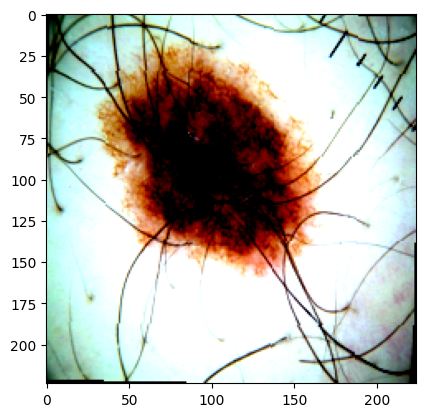

In [47]:
transform = ImgTrainTransform0()
# convert image to numpy array
x = transform(image)

# convert Image data of dtype object to float
plt.imshow(x.permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


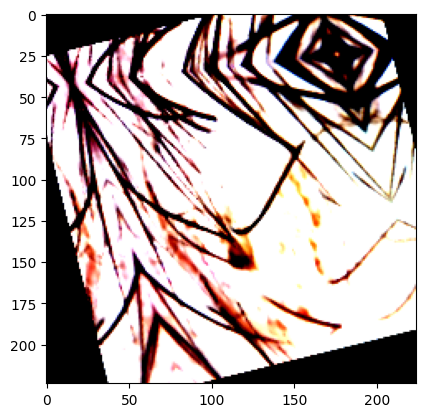

In [4]:
transform = ImgTrainTransform4()
# convert image to numpy array
x = transform(np.array(image, dtype=np.uint8))

# convert Image data of dtype object to float
plt.imshow(x.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[ 0.7077,  0.7419,  0.7591,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.6392,  0.6906,  0.7591,  ..., -2.1179, -2.1179, -2.1179],
         [ 0.6049,  0.6563,  0.7419,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[ 0.5028,  0.5203,  0.6078,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.4503,  0.4853,  0.5728,  ..., -2.0357, -2.0357, -2.0357],
         [ 0.4153,  0.4503,  0.5553,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[ 0.6182,  0.6356,  0.7054,  ..., -1.8044, -1.8044, -1.8044],
         [ 0.5485,  0.6008,  0.6879,  ..., -1

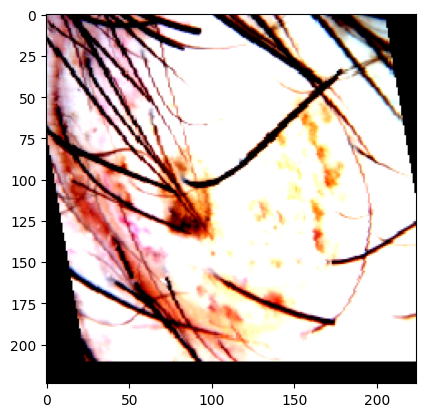

In [22]:
transform = ImgTrainTransform3()
x = transform(image)
plt.imshow(x.permute(1,2,0))
print(x)